In [1]:
from google.colab import drive
drive.mount('/content/drive')

project_dir = "/content/drive/My Drive/Colab Notebooks/COSE474 Deep Learning HW/20242R0136COSE47402/Final Project"
image_dir = pkl_dir = project_dir + "/data/scatterplots"

Mounted at /content/drive


In [2]:
!pip install transformers datasets
!pip install accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 18.8 MB/s eta 0:00:00


In [3]:
#Load dataset
from datasets import Dataset, DatasetDict
from PIL import Image
import pickle

with open(pkl_dir+'/dataset.pkl', 'rb') as f:
    loaded_dataset = pickle.load(f)

tied_dataset = { 'image':[], 'text':[] }

for i in range(len(loaded_dataset)):
  tied_dataset['image'].append(Image.open(loaded_dataset[i]['image']))
  tied_dataset['text'].append(loaded_dataset[i]['text'])

dataset = Dataset.from_dict(tied_dataset)


dataset_dict = DatasetDict({
    "train": dataset.select(range(64)),  # 첫 64개를 train으로
    "validation": dataset.select(range(64, 80))  # 나머지 16개를 validation으로
})

print(dataset_dict)
#print(loaded_dataset[255])


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 64
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 16
    })
})


#Use DEPLOT

In [11]:
# Load model directly
from transformers import AutoProcessor, AutoModelForImageTextToText
import torch

device = torch.device("cuda")
processor = AutoProcessor.from_pretrained("google/deplot")
model = AutoModelForImageTextToText.from_pretrained("google/deplot").to(device)

KeyboardInterrupt: 

In [ ]:
from PIL import Image
import os

path = "/content/drive/My Drive/Colab Notebooks/COSE474 Deep Learning HW/20242R0136COSE47402/Final Project"

# get images from /data/images directory
filenames =[]
images = []
for filename in os.listdir((path+'/data/images')):
  filenames.append(filename)
  images.append(Image.open(path+'/data/images/'+filename))
print(filenames)
images[2]

In [ ]:
inputs = processor(images=images[2], text="Generate underlying data table of the figure below:", return_tensors="pt").to(device)
predictions = model.generate(**inputs, max_new_tokens=512)
table = processor.decode(predictions[0], skip_special_tokens=True)
print(table.replace('<0x0A>','\n'))
print(predictions)

#Fine-tune DEPLOT

In [4]:
import torch
from transformers import Pix2StructForConditionalGeneration, Pix2StructProcessor, TrainingArguments, Trainer
#from transformers import Pix2StructForConditionalGeneration, Pix2StructProcessor, TrainingArguments, Trainer
from datasets import load_dataset
from torch.nn import CrossEntropyLoss
from PIL import Image

import os

# Check for CUDA availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load pre-trained model and processor
processor = Pix2StructProcessor.from_pretrained("google/deplot")
model = Pix2StructForConditionalGeneration.from_pretrained("google/deplot").to(device)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.62k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

In [5]:
def preprocess_function(examples):
  """
  데이터 전처리 함수:
  - AutoProcessor를 사용해 이미지와 텍스트 데이터를 처리.
  """

  inputs = processor(
    images=examples["image"],
    text="Generate underlying data table of the figure below:",
    return_tensors="pt",
    padding=True,
    truncation=True
  )

    # text 전처리 (토큰화)
  labels = processor.tokenizer(
    examples["text"],
    return_tensors="pt",
    padding=True,
    truncation=True
  )

    # 반환
  return {
    "flattened_patches": inputs["flattened_patches"].squeeze(0),  # 배치 차원 제거
    "attention_mask": inputs["attention_mask"].squeeze(0),
    "labels": labels["input_ids"].squeeze(0)
  }

# 데이터셋 전처리
tokenized_dataset = dataset_dict.map(preprocess_function, batched=True)

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Arial.TTF:   0%|          | 0.00/276k [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/16 [00:00<?, ? examples/s]

In [6]:
print(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'text', 'flattened_patches', 'attention_mask', 'labels'],
        num_rows: 64
    })
    validation: Dataset({
        features: ['image', 'text', 'flattened_patches', 'attention_mask', 'labels'],
        num_rows: 16
    })
})


In [7]:
class DeplotTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False,  num_items_in_batch=None):
    """
    Custom Loss Function:
    - 모델 출력 logits와 레이블 사이에서 CrossEntropyLoss 계산
    """
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.logits

    # Ignore -100 padding tokens
    loss_fct = CrossEntropyLoss(ignore_index=processor.tokenizer.pad_token_id)
    loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))

    return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
  output_dir="./results",             # 모델 출력 디렉토리
  evaluation_strategy="epoch",        # 에폭 단위 평가
  per_device_train_batch_size=2,      # 배치 크기
  per_device_eval_batch_size=2,       # 평가 배치 크기
  gradient_accumulation_steps=2,    # 작은 배치 2번 축적 (배치 크기 효과적으로 증가)
  num_train_epochs=3,                 # 에폭 수
  logging_dir="./logs",               # 로그 디렉토리
  logging_steps=10,                   # 로그 기록 간격
  save_strategy="epoch",              # 모델 저장 주기
  learning_rate=5e-5,                 # 학습률
  weight_decay=0.01,                  # Weight Decay
  save_total_limit=2,                 # 저장할 체크포인트 수 제한
  fp16=True,                           # FP16 혼합 정밀도 학습 사용 (GPU 권장)
  report_to="none"
)

# 5. Trainer 인스턴스 생성
trainer = DeplotTrainer(
  model=model,
  args=training_args,
  train_dataset=tokenized_dataset["train"],
  eval_dataset=tokenized_dataset["validation"],
  tokenizer=processor
)

# 6. 모델 훈련 시작
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-0e80b150f738>:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DeplotTrainer.__init__`. Use `processing_class` instead.
  trainer = DeplotTrainer(


Epoch,Training Loss,Validation Loss
1,2.215500,1.841813
2,1.866500,1.810132
3,1.852700,1.800805


TrainOutput(global_step=48, training_loss=1.937626560529073, metrics={'train_runtime': 285.4473, 'train_samples_per_second': 0.673, 'train_steps_per_second': 0.168, 'total_flos': 4.312863330847949e+17, 'train_loss': 1.937626560529073, 'epoch': 3.0})

In [ ]:
images[2]

['plot1.png', 'plot2.png', 'plot3.png', 'handplot.jpg', 'scatterplot.png']


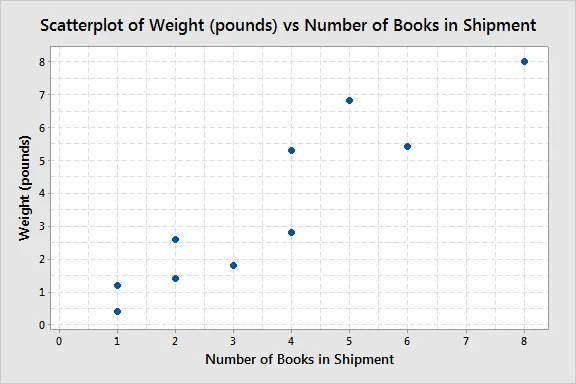

In [8]:
from PIL import Image
import os

path = "/content/drive/My Drive/Colab Notebooks/COSE474 Deep Learning HW/20242R0136COSE47402/Final Project"

# get images from /data/images directory
filenames =[]
images = []
for filename in os.listdir((path+'/data/images')):
  filenames.append(filename)
  images.append(Image.open(path+'/data/images/'+filename))
print(filenames)
images[2]

In [9]:
inputs = processor(images=images[2], text="Generate underlying data table of the figure below:", return_tensors="pt").to(device)
predictions = model.generate(**inputs, max_new_tokens=512)
table = processor.decode(predictions[0], skip_special_tokens=True)
print(table.replace('<0x0A>','\n'))
print(predictions)

TITLE | Scatterplot of Weight (pounc) vs Number of Books in Shipment
Number of Books in Shipment | Weight (pounc)
0 | 0.550000000000000
1 | 1.1900000000000000
2 | 2.6000000000000000
3 | 1.8000000000000000
4 | 5.2900000000000000
5 | 6.8500000000000000
6 | 5.4500000000000000
7 | 7.999999999999999
8 | 8.0000000000000000
tensor([[    0, 36757,   789,   562,  7926,  4891, 18973,   280, 13687,   304,
          8642,  1827,   565,   308,  1797,  4445,   280,  5456,   286, 15820,
          3659,    27,  8047,   280,  5456,   286, 15820,  3659,   789, 13687,
           304,  8642,  1827,   565,   308,    27,   278,   789,   273,   278,
           274,   290,   290,   278,   278,   278,   278,   278,   278,   278,
           278,   278,   278,   278,   278,   278,    27,   277,   789,   273,
           277,   274,   277,   292,   278,   278,   278,   278,   278,   278,
           278,   278,   278,   278,   278,   278,   278,   278,    27,   279,
           789,   273,   279,   274,   293,   278